# 0. Librerias necesarias

In [15]:
import warnings 
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy import ndimage
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                            precision_score, recall_score, f1_score, roc_curve, auc)

# 1. Análisis Exploratrorio

Descripcion de las bases:


1. ORIGA(-light) contiene 650 imágenes retinianas anotadas por profesionales formados del Instituto de Investigación Ocular de Singapur.

    La base de datos está compuesta por un conjunto de imágenes y un archivo en formato CSV que contiene las columnas que se aprecian a continuación:

    Las  columnas (Image, CDR, Ecc-Cup, Ecc-Disc)  corresponden a variables explicativas y la última (Glaucoma) corresponde a nuestra variable clasificatoria.

    Cada una de estas columnas se explica de la siguiente manera:


    - Image: Nombre de archivo de imagen.
    - Source: Fuente del dato
    - CDR: Cup-to-Disc Ratio. Proporción entre el diámetro del "cup" (excavación central) y el disco óptico. Valor clave en la detección de glaucoma..
    - Ecc-Cup: Excentricidad de la región de excavación del nervio óptico (cup). Una medida morfológica.
    - Ecc-Disc: Excentricidad del disco óptico completo. Ayuda a describir la forma del disco.
    - Glaucoma: Variable clasificatoria que identifica el diagnóstico negativo (0) o positivo (1) del glaucoma

2. G1020 esta base de datos consta de 1020 imágenes de fondo de ojo en color de alta resolución y proporciona anotaciones de la verdad fundamental para el diagnóstico del glaucoma.

    La base de datos está compuesta por un conjunto de imágenes y un archivo en formato CSV en donde se encuentra el label de la variable predictora (Glaucoma)

Cargamos las bases

In [44]:
df_origa = pd.read_csv('ORIGA/origa_info.csv')
df_g1020 = pd.read_csv('G1020/G1020.csv')
df_refuge_train = pd.read_json('REFUGE/train/index.json', orient='index')
df_refuge_test = pd.read_json('REFUGE/test/index.json', orient='index') ## esta no tiene label
df_g1020

,imageID,binaryLabels
0,image_0.jpg,0
1,image_1.jpg,0
2,image_3.jpg,0
3,image_4.jpg,0
4,image_5.jpg,0
...,...,...
1015,image_3198.jpg,0
1016,image_3199.jpg,0
1017,image_3201.jpg,1
1018,image_3202.jpg,1


Unificamos los dataframes

In [42]:
#Identifico la base
df_origa['Source'] = 'ORIGA'
df_g1020['Source'] = 'G1020'
df_refuge_train['Source'] = 'REFUGE'

#Renombro columnas
df_g1020 = df_g1020.rename(columns={'imageID': 'Image','binaryLabels': 'Glaucoma'})
df_refuge_train = df_refuge_train.rename(columns={'ImgName': 'Image','Label': 'Glaucoma'})

#Uno las bases
df_glacuoma = pd.concat([df_origa[['Image', 'Source', 'Glaucoma']],
                      df_g1020[['Image', 'Source', 'Glaucoma']],
                      df_refuge_train[['Image', 'Source', 'Glaucoma']]], ignore_index=True)


conteo = df_glacuoma.groupby('Source').size().reset_index(name='Cantidad')
print(conteo)

df_glacuoma.head

   Source  Cantidad
0   G1020      1020
1   ORIGA       650
2  REFUGE       400


<bound method NDFrame.head of           Image  Source  Glaucoma
0       001.jpg   ORIGA         0
1       002.jpg   ORIGA         0
2       003.jpg   ORIGA         0
3       004.jpg   ORIGA         0
4       005.jpg   ORIGA         0
...         ...     ...       ...
2065  n0356.jpg  REFUGE         0
2066  n0357.jpg  REFUGE         0
2067  n0358.jpg  REFUGE         0
2068  n0359.jpg  REFUGE         0
2069  n0360.jpg  REFUGE         0

[2070 rows x 3 columns]>

Revisamos la proporción de la variable objetivo:

In [19]:
labels_counts = df_glacuoma["Glaucoma"].value_counts()
labels_counts

Glaucoma
0    1566
1     504
Name: count, dtype: int64

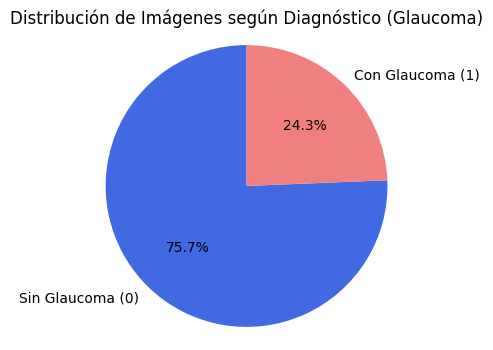

In [20]:
plt.figure(figsize=(4, 4))
plt.pie(labels_counts, 
        labels=['Sin Glaucoma (0)', 'Con Glaucoma (1)'],
        autopct='%1.1f%%',
        colors=['royalblue', 'lightcoral'],
        startangle=90)
plt.title('Distribución de Imágenes según Diagnóstico (Glaucoma)')
plt.axis('equal')  # Para que sea un círculo perfecto
plt.show()



Revisamos la distribución de CDR por la clasificación de Glaucoma (solo aplica para la base ORIGA)

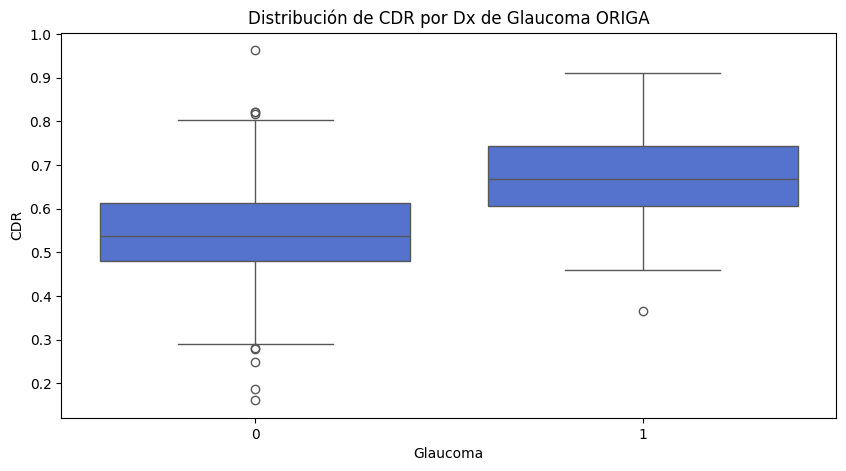

In [45]:
plt.figure(figsize=(10,5))

sns.boxplot(x='Glaucoma', y='CDR', data=df_origa, color="royalblue")
plt.title('Distribución de CDR por Dx de Glaucoma ORIGA')
plt.show()


Agregamos la ruta completa de la imagen al dataset

In [ ]:

# Rutas diferentes para cada base de datos
root_origa = "ORIGA\Images"
root_g1020 = "G1020\Images"
root_refuge = "REFUGE\\train\Images"


# Función para aplicar la ruta correcta
def get_image_path(row):
    if row['Source'] == 'ORIGA':
        return os.path.join(root_origa, row['Image'])
    elif row['Source'] == 'G1020':
        return os.path.join(root_g1020, row['Image'])
    elif row['Source'] == 'REFUGE':
        return os.path.join(root_refuge, row['Image'])
    else:
        return None  # En caso de que no coincida con ninguna base

# Aplicar la función a cada fila para crear la columna 'Path'
df_glacuoma['Path'] = df_glacuoma.apply(get_image_path, axis=1)

# Verificar los resultados

df_glacuoma[df_glacuoma["Source"] == "REFUGE"].head()

,Image,Source,Glaucoma,Path
1670,g0001.jpg,REFUGE,1,REFUGE\train\Images\g0001.jpg
1671,g0002.jpg,REFUGE,1,REFUGE\train\Images\g0002.jpg
1672,g0003.jpg,REFUGE,1,REFUGE\train\Images\g0003.jpg
1673,g0004.jpg,REFUGE,1,REFUGE\train\Images\g0004.jpg
1674,g0005.jpg,REFUGE,1,REFUGE\train\Images\g0005.jpg


Las imágenes que provee el dataset corresponden a fondos oculares como las siguientes:

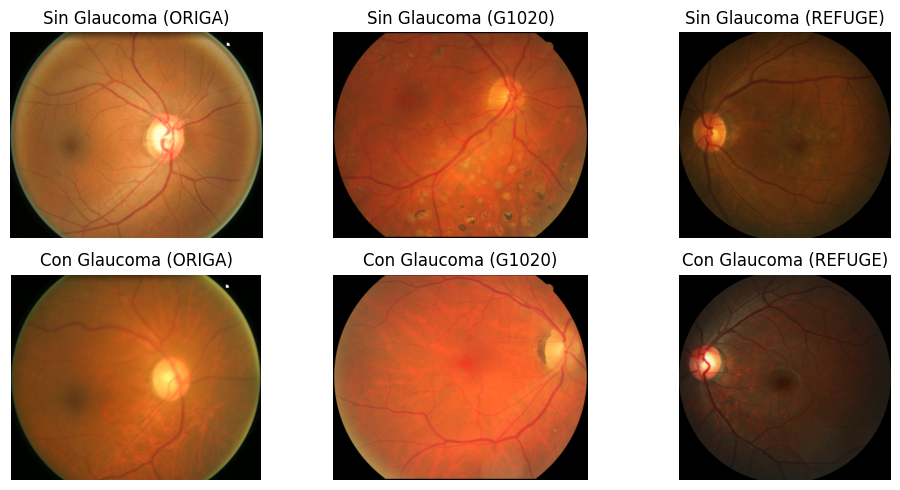

In [23]:
# Obtener ruta de una imagen con Glaucoma = 0 (sin glaucoma)
img_path_0 = df_glacuoma[(df_glacuoma["Glaucoma"] == 0) & (df_glacuoma["Source"] == "ORIGA")]["Path"].iloc[0]
img_0 = Image.open(img_path_0)

# Obtener ruta de una imagen con Glaucoma = 1 (con glaucoma)
img_path_1 = df_glacuoma[(df_glacuoma["Glaucoma"] == 0) & (df_glacuoma["Source"] == "G1020")]["Path"].iloc[0]
img_1 = Image.open(img_path_1)

# Obtener ruta de una imagen con Glaucoma = 1 (con glaucoma)
img_path_2 = df_glacuoma[(df_glacuoma["Glaucoma"] == 0) & (df_glacuoma["Source"] == "REFUGE")]["Path"].iloc[0]
img_2 = Image.open(img_path_2)

# Obtener ruta de una imagen con Glaucoma = 0 (sin glaucoma)
img_path_3 = df_glacuoma[(df_glacuoma["Glaucoma"] == 1) & (df_glacuoma["Source"] == "ORIGA")]["Path"].iloc[0]
img_3 = Image.open(img_path_3)

# Obtener ruta de una imagen con Glaucoma = 1 (con glaucoma)
img_path_4 = df_glacuoma[(df_glacuoma["Glaucoma"] == 1) & (df_glacuoma["Source"] == "G1020")]["Path"].iloc[0]
img_4 = Image.open(img_path_4)

# Obtener ruta de una imagen con Glaucoma = 1 (con glaucoma)
img_path_5 = df_glacuoma[(df_glacuoma["Glaucoma"] == 1) & (df_glacuoma["Source"] == "REFUGE")]["Path"].iloc[0]
img_5 = Image.open(img_path_5)


fig, axes = plt.subplots(2, 3, figsize=(10,5))

axes[0,0].imshow(img_0)
axes[0,0].set_title("Sin Glaucoma (ORIGA)")
axes[0,0].axis("off")

axes[0,1].imshow(img_1)
axes[0,1].set_title("Sin Glaucoma (G1020)")
axes[0,1].axis("off")

axes[0,2].imshow(img_2)
axes[0,2].set_title("Sin Glaucoma (REFUGE)")
axes[0,2].axis("off")

axes[1,0].imshow(img_3)
axes[1,0].set_title("Con Glaucoma (ORIGA)")
axes[1,0].axis("off")

axes[1,1].imshow(img_4)
axes[1,1].set_title("Con Glaucoma (G1020)")
axes[1,1].axis("off")

axes[1,2].imshow(img_5)
axes[1,2].set_title("Con Glaucoma (REFUGE)")
axes[1,2].axis("off")

plt.tight_layout()
plt.show()


Las imágenes anteriores muestran fondos oculares diagnosticados de glaucoma de forma negativa (fila superior) y positiva (fila inferior).

# 2. Feature Enginier

### 2.1. Extraer la Región de Interés (revisar)

Queremos trabajar solo con el área relevante con el fin de eliminar el "ruido" al momento de entrenar el modelo

In [ ]:
#tarda 5 min
images = []
threshs = []
images_cropped = []

for i, image_path in enumerate(df_glacuoma['Path']):

    # Cargar la imagen y convertirla a escala de grises
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Aplicar umbral para obtener una imagen binaria
    threshold = 200
    _, thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)

    # Detectar los contornos y seleccionar el más grande
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    if contours:
        # Contorno más grande (suponiendo que es el disco óptico)
        largest = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest)

        # Calcular un rectángulo delimitador alrededor del contorno y ampliar el área para incluir un margen.
        pad = 300
        x1 = max(x - pad, 0)
        y1 = max(y - pad, 0)
        x2 = min(x + w + pad, img.shape[1])
        y2 = min(y + h + pad, img.shape[0])

        # Recortar la imagen en función de las coordenadas calculadas.
        img_cropped = img[y1:y2, x1:x2]

        # Mostrar la imagen recortada
        # plt.imshow(img_cropped)
        # plt.show()
        # print('Imagen recortada')
    else:
        # # No se encontró ROI, mostrar imagen original
        # plt.imshow(img)
        # plt.show()
        print('No se encontro Región de Interés',image_path)

    images.append(img)    
    threshs.append(thresh)    
    images_cropped.append(img_cropped)   

No se encontro Región de Interés ORIGA\Images\372.jpg
No se encontro Región de Interés G1020\Images\image_0.jpg
No se encontro Región de Interés G1020\Images\image_10.jpg
No se encontro Región de Interés G1020\Images\image_12.jpg
No se encontro Región de Interés G1020\Images\image_46.jpg
No se encontro Región de Interés G1020\Images\image_49.jpg
No se encontro Región de Interés G1020\Images\image_50.jpg
No se encontro Región de Interés G1020\Images\image_64.jpg
No se encontro Región de Interés G1020\Images\image_77.jpg
No se encontro Región de Interés G1020\Images\image_78.jpg
No se encontro Región de Interés G1020\Images\image_103.jpg
No se encontro Región de Interés G1020\Images\image_107.jpg
No se encontro Región de Interés G1020\Images\image_110.jpg
No se encontro Región de Interés G1020\Images\image_120.jpg
No se encontro Región de Interés G1020\Images\image_123.jpg
No se encontro Región de Interés G1020\Images\image_125.jpg
No se encontro Región de Interés G1020\Images\image_171.

A continuación, observamos el proceso que hace el codigo anterior, tomamos la imagen original e identificamos las zonas de mayor brillo, a partir de allí recortamos la región de interés

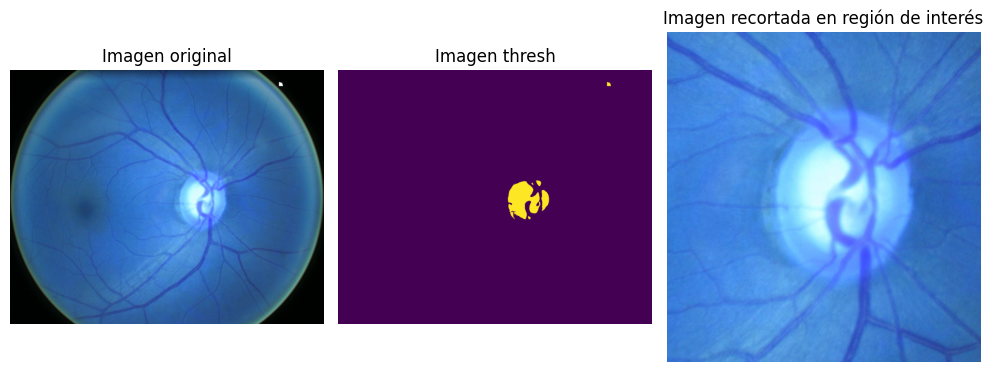

In [25]:
n = 0 # Selecciona la imagen

fig, axes = plt.subplots(1, 3, figsize=(10,5))

axes[0].imshow(images[n])
axes[0].set_title("Imagen original")
axes[0].axis("off")

axes[1].imshow(threshs[n])
axes[1].set_title("Imagen thresh")
axes[1].axis("off")

axes[2].imshow(images_cropped[n])
axes[2].set_title("Imagen recortada en región de interés")
axes[2].axis("off")

plt.tight_layout()
plt.show()  

### 2.2. Redimensionar

Reducimos el tamaño a algo uniforme (por ejemplo, 256x256 o 224x224) para que el modelo pueda recibir todas las imágenes del mismo tamaño

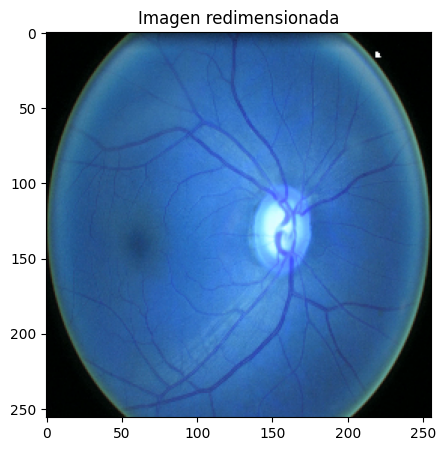

In [26]:
images_resize = []

for image in images:
    img_resize = cv2.resize(image, (256, 256)) #Redimensionar 
    # img_resize = cv2.resize(image, (224, 224)) #Redimensionar 
    images_resize.append(img_resize)  

del images ## borro para no saturar la RAM
del threshs ## borro para no saturar la RAM
del images_cropped ## borro para no saturar la RAM

plt.figure(figsize=(5,5))
plt.imshow(images_resize[0])  
plt.title("Imagen redimensionada")
# plt.axis("off")  
plt.show()


### 2.3. Conversión a escala de grises (Evaluar dependiendo del modelo)

CLAHE = Contrast Limited Adaptive Histogram Equalization


CLAHE es una técnica que mejora el contraste localmente, haciendo visibles detalles importantes, especialmente en imágenes médicas. Es útil en imágenes de retina para resaltar estructuras como el disco óptico y los vasos sanguíneos.

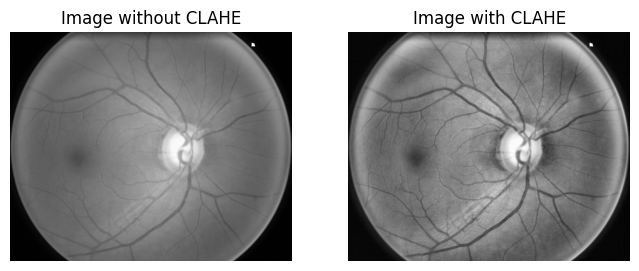

In [ ]:
sample_image_path= df_glacuoma.loc[0,'Path'] 
sample_image=cv2.imread(sample_image_path,cv2.IMREAD_GRAYSCALE)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) # Parametros clave para los ajustes de contraste
image_clahe = clahe.apply(sample_image) 

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(sample_image,cmap = 'gray')
plt.title("Image without CLAHE")
plt.axis(False)

plt.subplot(1,2,2)
plt.imshow(image_clahe,cmap='gray')
plt.title("Image with CLAHE")
plt.axis(False)

plt.show()

Esta configuracion de CLAHE es recomentada para tratar con la imagenes de retina ya que permite mejorar el brillo y contraste sin alterar los colores

In [28]:
images_clahe = []

for image in images_resize:

    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb) # Convierte la imagen de BGR a YCrCb, que es un espacio de color que separa la luminancia del color
    y = ycrcb[:, :, 0] 

    # Y = Luminancia (lo que percibimos como brillo) → este canal contiene la información de textura, bordes, contraste.
    # Cr, Cb = Información de color (crominancia, rojo y azul respectivamente).
    # Usar YCrCb permite mejorar el brillo y el contraste sin distorsionar los colores.

    # Aplicar CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    y_clahe = clahe.apply(y)

    # Reemplazar canal Y y convertir de nuevo
    ycrcb[:, :, 0] = y_clahe
    img_clahe = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR) #Convierte la imagen de vuelta a BGR, para poder visualizarla normalmente

    images_clahe.append(img_clahe) 

del images_resize ## borro para no saturar la RAM

Visualizamos la imagen luego de aplicar CLAHE, observamos que mejora el brillo y contraste lo que facilita identificar patrones relevantes en la detección de Glaucoma

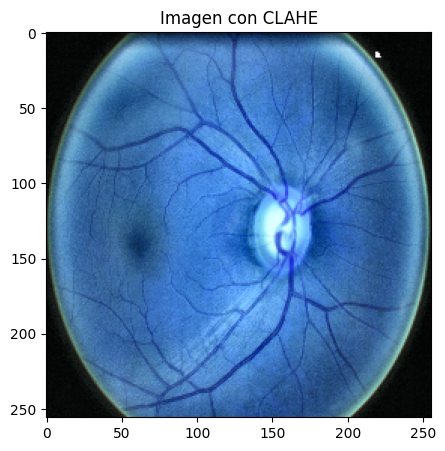

In [29]:
plt.figure(figsize=(5,5))
plt.imshow(images_clahe[0])  
plt.title("Imagen con CLAHE")
# plt.axis("off")  
plt.show()

### 2.4. Normalizar

Normalizamos los valores de píxel a [0, 1] o [-1, 1]

In [30]:
images_norm = []

for image in images_clahe:
    img_norm = image / 255.0  

    images_norm.append(img_norm) 

del images_clahe ## borro para no saturar la RAM

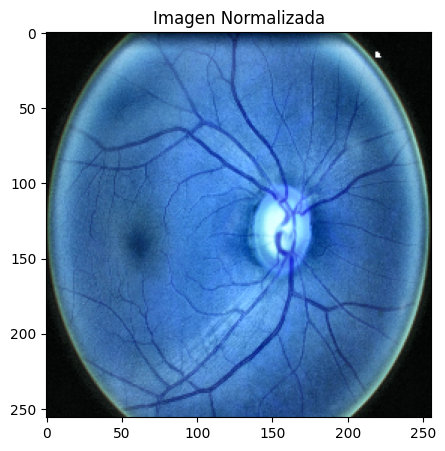

In [31]:
plt.figure(figsize=(5,5))
plt.imshow(images_norm[0])  
plt.title("Imagen Normalizada")
# plt.axis("off")  
plt.show()

# 3. Modelo

Dividimos la variable objetivo de la variable explicativa

In [32]:
X = np.array(images_norm, dtype=np.float32)
y = df_glacuoma["Glaucoma"].values.astype(np.float32)

Aplanamos las imagenes para que puedan ser leidas por el modelo

In [33]:
X_flat = X.reshape(X.shape[0], -1)  # Convierte cada imagen en un vector de una sola dimensión

Partimos la base de entranamiento y test

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, stratify=y, random_state=42)

### 3.1. Random Forest

In [35]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.98      0.86       313
         1.0       0.64      0.09      0.16       101

    accuracy                           0.77       414
   macro avg       0.71      0.54      0.51       414
weighted avg       0.74      0.77      0.69       414



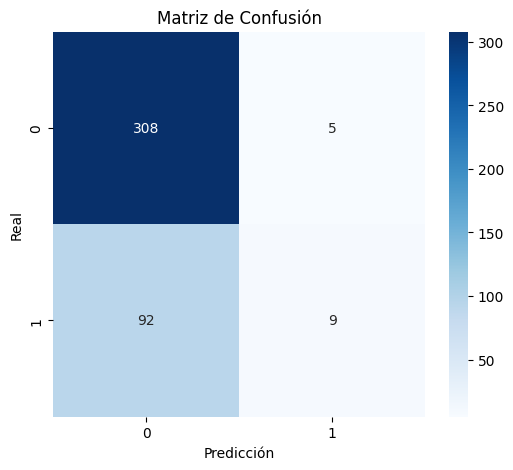

In [36]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

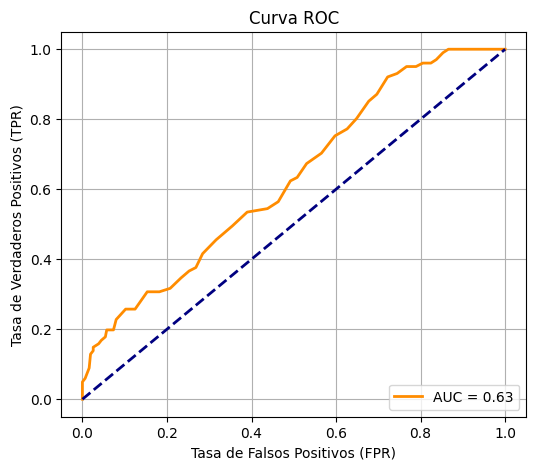

In [37]:
y_proba = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


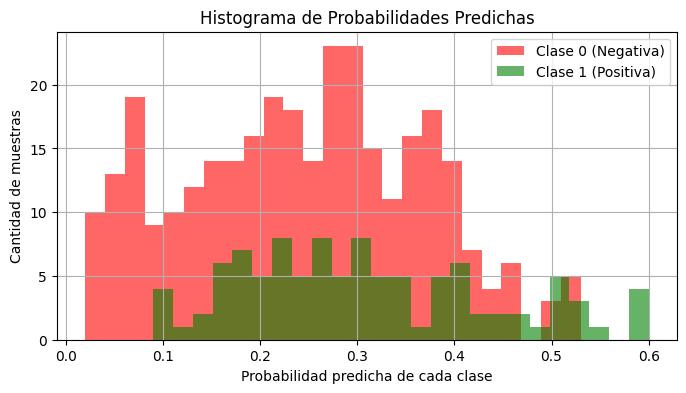

In [38]:
plt.figure(figsize=(8, 4))

# Probabilidades para la clase 0
plt.hist(y_proba[y_test == 0], bins=25, alpha=0.6, color='red', label='Clase 0 (Negativa)')
# Probabilidades para la clase 1
plt.hist(y_proba[y_test == 1], bins=25, alpha=0.6, color='green', label='Clase 1 (Positiva)')


plt.title('Histograma de Probabilidades Predichas')
plt.xlabel('Probabilidad predicha de cada clase')
plt.ylabel('Cantidad de muestras')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


Pendiente a implementar

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range=90,      # rotaciones aleatorias
    horizontal_flip=True,   # voltear horizontalmente
    vertical_flip=True      # voltear verticalmente
)

train_datagenerator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='ORIGA/Images',
    x_col='Path',
    y_col='Glaucoma',
    target_size=(256, 256),
    batch_size=8,
    class_mode='binary',
    seed=42
)

ModuleNotFoundError: No module named 'tensorflow'